In [44]:
%matplotlib ipympl

from onix.data_tools import get_experiment_data
from functools import partial
from onix.analysis.fitter import Fitter
from onix.analysis.helper import data_groups
import numpy as np
from matplotlib import colormaps
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.special import voigt_profile

In [45]:
def p_excited(t, Omega, delta, tau):
    Omega_gen = np.sqrt(Omega**2 + delta**2)
    offset = Omega ** 2 / Omega_gen ** 2 / 2
    return offset + (Omega ** 2 / Omega_gen ** 2 * np.sin(Omega_gen * t / 2) ** 2 - offset) * np.exp(-t / tau)

span = 30e3*2*np.pi
def uniform_inhomogenous_broadening(delta):
    return np.heaviside(span - delta, 0.5) * np.heaviside(delta + span, 0.5) / (2 * span)
    
def p_excited_with_inhomogenous(t, a, Omega, tau, c):
    def integrand(delta):
        return p_excited(t, Omega, delta, tau) * uniform_inhomogenous_broadening(delta)
    return a * quad(integrand, -span, span)[0] + c
    
def p_excited_with_inhomogenous_1(t, Omega, a, tau, c, scale_factor):
    def integrand(delta):
        return p_excited(t, Omega * scale_factor, delta, tau) * uniform_inhomogenous_broadening(delta)
    return a * quad(integrand, -span, span)[0] + c

In [614]:
def gaussian(f, f_0, a, sigma, b, c):
    numerator = (f - f_0) ** 2
    denominator = 2 * sigma ** 2
    return a * np.exp(-numerator / denominator) + c + b * (f - f_0)

def get_gaussian_fit(detunings, voltages, p0=None):
    fitter = Fitter(gaussian)
    fitter.set_absolute_sigma(False)
    fitter.set_data(detunings, voltages)
    fitter.set_p0({"f_0": 0})
    #fitter.set_bounds("a", -np.inf, 0)
    #fitter.set_bounds("c", 0, np.inf)
    #fitter.set_p0({"a": -1})
    if p0 is not None:
        fitter.set_p0(p0)
    fitter.fit()
    
    return fitter

def gaussian0(f, f0, a, sigma): 
    return a * np.exp( -(f - f0) **2 / (2 * sigma ** 2) )

def four_peak_gaussian(f, f1, f2, f3, f4, a1, a2, a3, a4, sigma1, sigma2, sigma3, sigma4):
    return gaussian0(f, f1, a1, sigma1) + gaussian0(f, f2, a2, sigma2) + gaussian0(f, f3, a3, sigma3) + gaussian0(f, f4, a4, sigma4) + c

def linear(x, a, b):
    return x * a + b

In [154]:
def rf_spectroscopy(data_list):
    antihole_heights = []
    antihole_height_errs = []
    rf_heights = []
    rf_height_errs = []
    offsets = []
    
    for kk in data_list:
        data, headers = get_experiment_data(kk)
        detunings = headers["detunings"].to("MHz").magnitude
        offset = headers["params"]["rf"]["offset_2"].to("kHz").magnitude
        offsets.append(offset)
        (chasm_avg, antihole_avg, rf_avg), (monitor_chasm_avg, monitor_antihole_avg, monitor_rf_avg) = data_groups(data, headers)

        # fit heights
        antihole_fit = get_gaussian_fit(detunings, antihole_avg/chasm_avg)
        antihole_heights.append(antihole_fit.results["a"])
        antihole_height_errs.append(antihole_fit.errors["a"])
        
        rf_fit = get_gaussian_fit(detunings, rf_avg/chasm_avg)
        rf_heights.append(rf_fit.results["a"])
        rf_height_errs.append(rf_fit.errors["a"])

    offsets = np.array(offsets)
    antihole_heights = np.array(antihole_heights)
    antihole_height_errs = np.array(antihole_height_errs)
    rf_heights = np.array(rf_heights)
    rf_height_errs = np.array(rf_height_errs)
    ratios = rf_heights / antihole_heights
    ratio_errs = ratios * np.sqrt((rf_height_errs / rf_heights) ** 2 + (antihole_height_errs / antihole_heights) ** 2)

    xs = offsets
    ys = ratios
    return xs, ys
    

In [155]:
def rf_spectroscopy_field(data_list):
    positive_antihole_heights = []
    positive_antihole_height_errs = []
    negative_antihole_heights = []
    negative_antihole_height_errs = []
    positive_rf_heights = []
    positive_rf_height_errs = []
    negative_rf_heights = []
    negative_rf_height_errs = []
    offsets = []
    
    for kk in data_list:
        data, headers = get_experiment_data(kk)
        detunings = headers["detunings"].to("MHz").magnitude
        offset = headers["params"]["rf"]["offset_2"].to("kHz").magnitude
        offsets.append(offset)
        (chasm_avg, antihole_avg, rf_avg), (monitor_chasm_avg, monitor_antihole_avg, monitor_rf_avg) = data_groups(data, headers)

        # fit heights
        positive_mask = detunings > 0
        positive_antihole_fit = get_gaussian_fit(detunings[positive_mask], antihole_avg[positive_mask]/chasm_avg[positive_mask], p0={"f_0": 2, "a": -0.1, "c": 1, "sigma": 0.3})
        positive_antihole_heights.append(positive_antihole_fit.results["a"])
        positive_antihole_height_errs.append(positive_antihole_fit.errors["a"])
        
        positive_rf_fit = get_gaussian_fit(detunings[positive_mask], rf_avg[positive_mask]/chasm_avg[positive_mask], p0={"f_0": 2, "a": -0.1, "c": 1, "sigma": 0.3})
        positive_rf_heights.append(positive_rf_fit.results["a"])
        positive_rf_height_errs.append(positive_rf_fit.errors["a"])
    
        negative_mask = detunings < 0
        negative_antihole_fit = get_gaussian_fit(detunings[negative_mask], antihole_avg[negative_mask]/chasm_avg[negative_mask], p0={"f_0": -2, "a": -0.1, "c": 1, "sigma": 0.3})
        negative_antihole_heights.append(negative_antihole_fit.results["a"])
        negative_antihole_height_errs.append(negative_antihole_fit.errors["a"])
        
        negative_rf_fit = get_gaussian_fit(detunings[negative_mask], rf_avg[negative_mask]/chasm_avg[negative_mask], p0={"f_0": -2, "a": -0.1, "c": 1, "sigma": 0.3})
        negative_rf_heights.append(negative_rf_fit.results["a"])
        negative_rf_height_errs.append(negative_rf_fit.errors["a"])

    offsets = np.array(offsets)
    positive_antihole_heights = np.array(positive_antihole_heights)
    positive_antihole_height_errs = np.array(positive_antihole_height_errs)
    negative_antihole_heights = np.array(negative_antihole_heights)
    negative_antihole_height_errs = np.array(negative_antihole_height_errs)
    positive_rf_heights = np.array(positive_rf_heights)
    positive_rf_height_errs = np.array(positive_rf_height_errs)
    negative_rf_heights = np.array(negative_rf_heights)
    negative_rf_height_errs = np.array(negative_rf_height_errs)
    positive_ratios = positive_rf_heights / positive_antihole_heights
    positive_ratio_errs = positive_ratios * np.sqrt((positive_rf_height_errs / positive_rf_heights) ** 2 + (positive_antihole_height_errs / positive_antihole_heights) ** 2)
    negative_ratios = negative_rf_heights / negative_antihole_heights
    negative_ratio_errs = negative_ratios * np.sqrt((negative_rf_height_errs / negative_rf_heights) ** 2 + (negative_antihole_height_errs / negative_antihole_heights) ** 2)

    xs = offsets
    positive_ys = positive_ratios
    negative_ys = negative_ratios
    return xs, positive_ys, negative_ys
    

In [156]:
def rf_flopping(data_list):
    antihole_heights = []
    antihole_height_errs = []
    rf_heights = []
    rf_height_errs = []
    times = []
    
    for kk in data_list:
        data, headers = get_experiment_data(kk)
        detunings = headers["detunings"].to("MHz").magnitude
        times.append(headers["params"]["rf"]["duration"].to("ms").magnitude)
        (chasm_avg, antihole_avg, rf_avg), (monitor_chasm_avg, monitor_antihole_avg, monitor_rf_avg) = data_groups(data, headers)

        # fit heights
        antihole_fit = get_gaussian_fit(detunings, antihole_avg/monitor_antihole_avg)
        antihole_heights.append(antihole_fit.results["a"])
        antihole_height_errs.append(antihole_fit.errors["a"])
        
        rf_fit = get_gaussian_fit(detunings, rf_avg/monitor_rf_avg)
        rf_heights.append(rf_fit.results["a"])
        rf_height_errs.append(rf_fit.errors["a"])

    times = np.array(times)
    antihole_heights = np.array(antihole_heights)
    antihole_height_errs = np.array(antihole_height_errs)
    rf_heights = np.array(rf_heights)
    rf_height_errs = np.array(rf_height_errs)
    ratios = rf_heights / antihole_heights
    ratio_errs = ratios * np.sqrt((rf_height_errs / rf_heights) ** 2 + (antihole_height_errs / antihole_heights) ** 2)

    xs = times
    ys = ratios
    return xs, ys
    

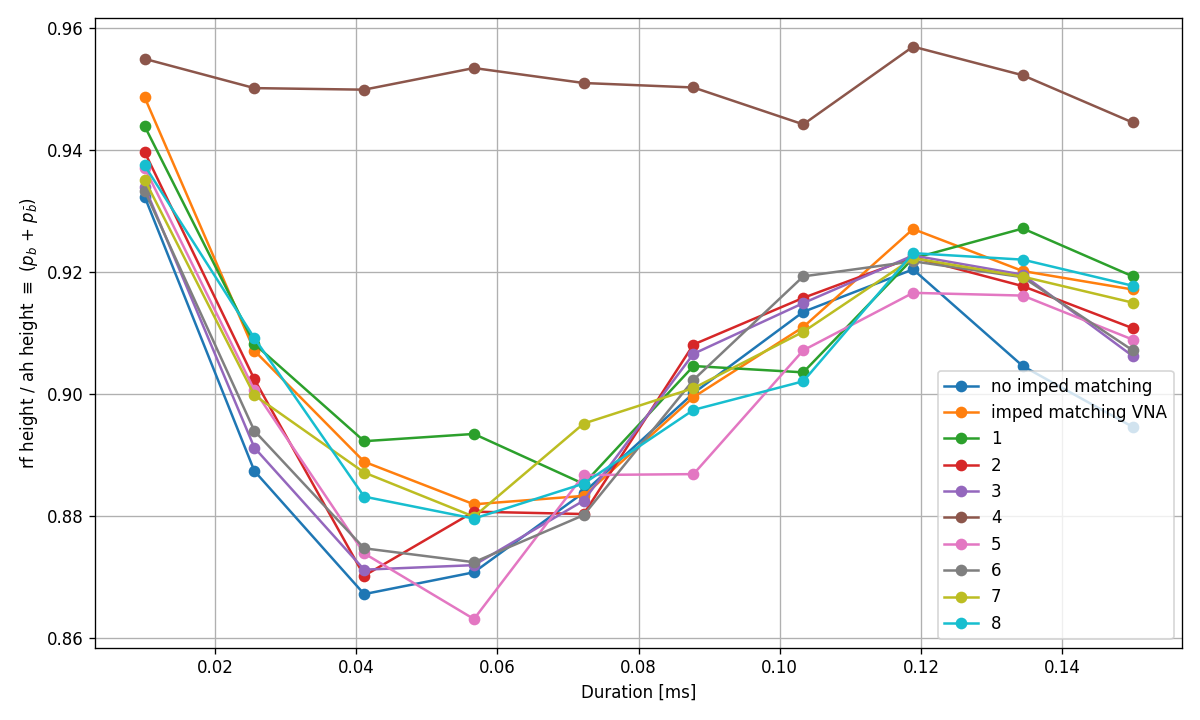

In [669]:
data = {
    # "$a\\to b$, amplitude 4200" : [16845, 16864],
    # "$a\\to b$, amplitude 1500" : [16999, 17008],
    # "$a\\to \\bar{b}$, amplitude 4200" : [17009, 17018],
    # "$a\\to \\bar{b}$, amplitude 2000" : [17019, 17028],
    # "1" : [21053, 21062],
    # "2": [21063, 21082],
    # "2": [21115, 21134],
    # "reverse": [21135, 21164]
    # "3 repeats, chasm per data point": [21165, 21174],
    # "1 repeat, 1 chasm": [21175, 21185],
    # "1 repeat, chasm per data point": [21186, 21196],
    # "1 repeat, chasm every 2nd data  point": [21204, 21214],
    # "1 repeat, chasm every 3rd data  point": [21215, 21225],

    # amplitude = 4200
    # "-45 kHz offset": [21248, 21257],
    # "90 kHz offset": [21268, 21277],
    # "-203 kHz": [21390, 21399],
    # "250 kHz": [21425, 21437],

    # "-45 kHz offset 2100": [21438, 21447],
    # "-45 kHz offset 1050": [21448, 21457],
    # "-45 kHz offset 1500": [21458, 21467],
    # "-45 kHz offset 400": [21468, 21477],
    # "-203 kHz offset 1500": [21478, 21493],
    # "1": [23032, 23039],
    # "2": [23040, 23047],
    # "3": [23048, 23055],
    # "4": [23056, 23063],
    # "5": [23064, 23071],
    # "6": [23072, 23079],
    # "7": [23080, 23087],
    # "8": [23088, 23095],
    # "9": [23096, 23103],
    # "10": [23104, 23111],
    # "11": [23112, 23119],
    # "12": [23120, 23127],
    # "13": [23128, 23135],
    # "14": [23136, 23143],
    # "15": [23144, 23151],
    # "16": [23152, 23159],
    # "17": [23160, 23167],
    # "18": [23168, 23175],
    # "19": [23176, 23183],
    # "20": [23184, 23191],
    # "21": [23192, 23199],
    # "22": [23200, 23207],
    # "23": [23208, 23215],
    # "24": [23216, 23223],
    # "25": [23224, 23231],
    # "26": [23232, 23239],
    # "27": [23240, 23247],
    # "28": [23248, 23255],
    # "29": [23256, 23263],
    # "29-2": [23264, 23283],
    # "30": [23284, 23291],
    # "30-2": [23292, 23311],
    # "30-3": [23312, 23314],
    # "31": [23315, 23317],
    # "32": [23318, 23320],
    # "33": [23321, 23323],
    # "34": [23324, 23326],
    # "35": [23327, 23330],
    # "36": [23331, 23334],
    # "Imped matching": [23367, 23386],
    # "No imped matching": [23427, 23466],
    # "Imped matching (VNA)": [23387, 23426],
    "no imped matching": [23467, 23476],
    "imped matching VNA": [23477, 23486],
    "1": [23487, 23496],
    "2": [23497, 23506],
    "3": [23507, 23516],
    "4": [23517, 23526],
    "5": [23527, 23536],
    "6": [23537, 23546],
    "7": [23547, 23556],
    "8": [23557, 23566],
    # "imp matching 2": [23567, 23576],
    # "no imp matching 2": [23577, 23586]

    # "-46": [23587, 23598],
    #"-213": [23599, 23608],
    #"-213 800": [23609, 23618],
    
    # shunt
    # "shunt": [32593, 32612],
    # "shunt" : [32613, 32642], 
    # "shunt" : [32643, 32672],
    # "no shunt" : [32673, 32702],
}

fig, ax = plt.subplots(figsize = (10, 6), dpi = 120)

for label, data_range in data.items():
    data_list = range(data_range[0], data_range[1]+1)
    xs, ys = rf_flopping(data_list)
    ax.plot(xs, ys, 'o-', label = label)
    
ax.set_xlabel("Duration [ms]")
ax.set_ylabel("rf height / ah height $\\equiv$ ($p_b$ + $p_\\bar{b}$)")
plt.legend()
plt.tight_layout()
plt.grid()
plt.show()

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 1200.

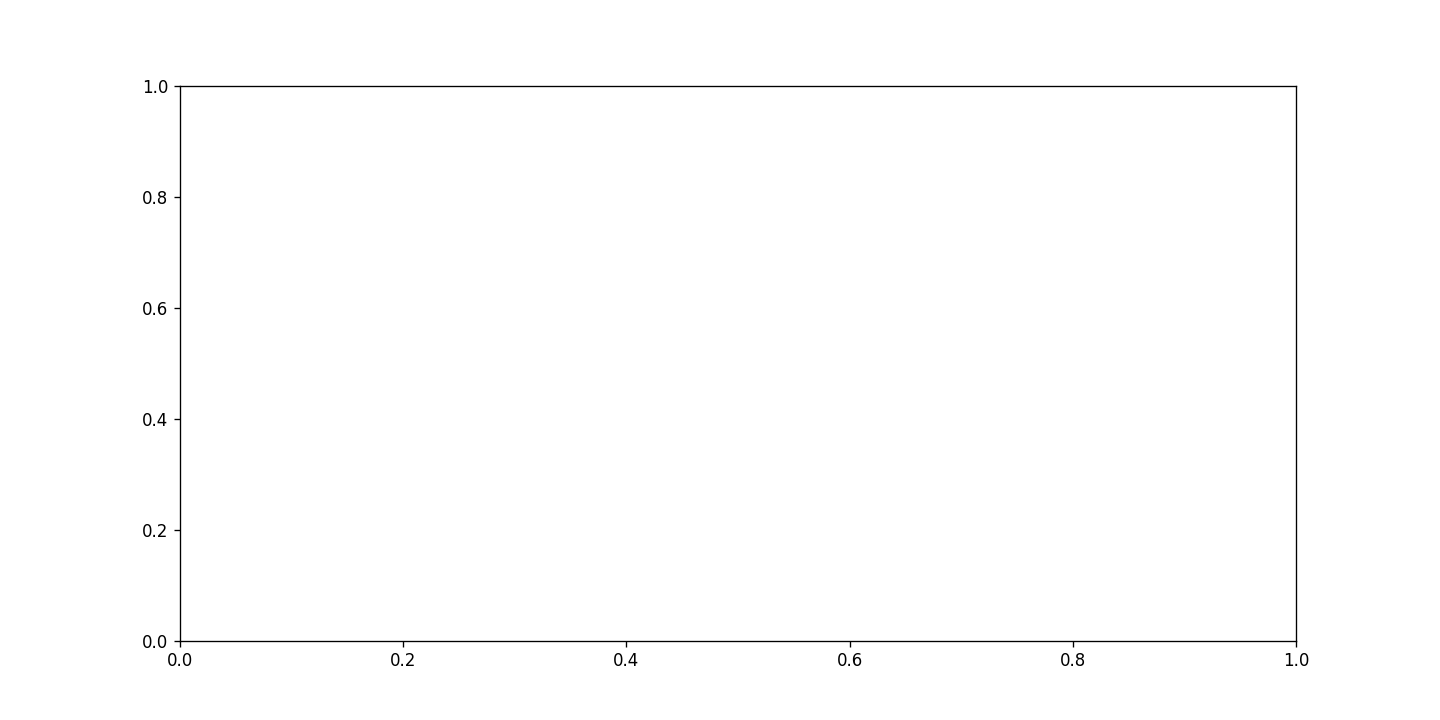

In [104]:
# data_list = range(3599, 3718)

data = {
    "test" : [15686, 15691],
}
fig, ax = plt.subplots(figsize = (12, 6), dpi = 120)

index = 0
for label, data_range in data.items():
    data_list = range(data_range[0], data_range[1]+1)
    xs, ys = rf_spectroscopy(data_list)
    ax.scatter(xs, ys, label=label, color=f"C{index}")
    index += 1
    
ax.set_xlabel("RF frequency - 119200 (kHz)")
ax.set_ylabel("rf height / ah height $\\equiv$ ($p_b$ + $p_\\bar{b}$)")
for ax in axs:
    ax.legend()
    ax.grid()
plt.tight_layout()
plt.show()

In [685]:
data_range = [36104, 36900]
scan_range = 10
scan_step = 1
# rf_offset_2s = np.arange(center_freq - scan_range, center_freq + scan_range, scan_step)
center_freqs = [258, -213, -46]  # -208, -41, 263

rf_offsets = np.array([np.arange(center_freq - scan_range, center_freq + scan_range, scan_step) for center_freq in center_freqs]).flatten()
print(detunings)
    

[ 248  249  250  251  252  253  254  255  256  257  258  259  260  261
  262  263  264  265  266  267 -223 -222 -221 -220 -219 -218 -217 -216
 -215 -214 -213 -212 -211 -210 -209 -208 -207 -206 -205 -204  -56  -55
  -54  -53  -52  -51  -50  -49  -48  -47  -46  -45  -44  -43  -42  -41
  -40  -39  -38  -37]


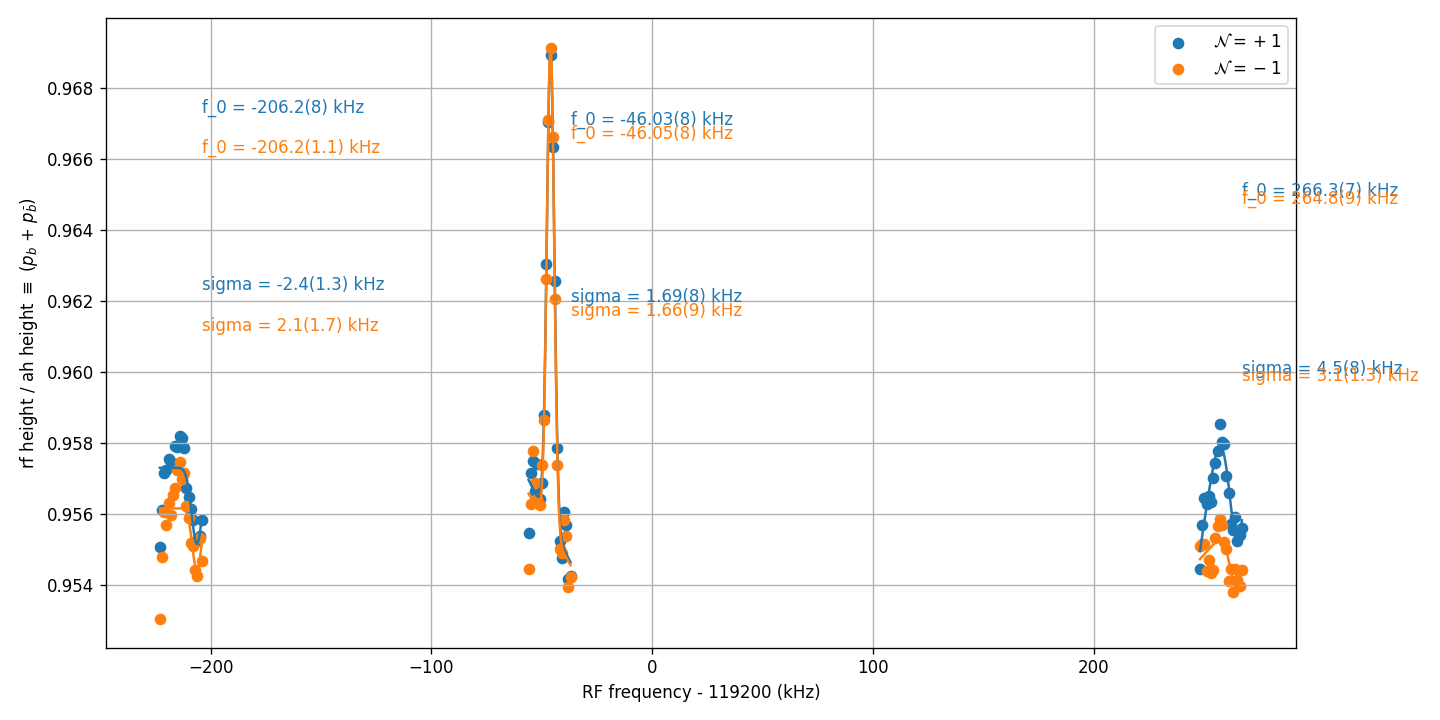

In [693]:
data = {
    #"$\\bar{a}\\to \\bar{b}$ depletion" : [13914, 14002],
    #"$a\\to b$ depletion": [15052, 15141],
    #"$a\\to b$ depletion": [15641, 15685],
    #"phase 0.0001": [15731, 15745],
    #"phase 0.05": [15761, 15775],
    #"phase 0.01": [15776, 15790],
    #"phase 0.005": [15791, 15805],
    #"phase 0.02": [15806, 15820],
    #"$a\\to b$ depletion": [15822, 16000],
    #"sweep 0 kHz, duration 0.4 ms": [16001, 16015],
    #"sweep 1 kHz, 0.4 ms": [16016, 16030],
    #"sweep 1 kHz, 0.8 ms": [16031, 16045],
    #"sweep 3 kHz, duration 3 ms": [16046, 16060],
    #"sweep 5 kHz, duration 5 ms": [16061, 16075],
    #"sweep 5 kHz, duration 10 ms": [16076, 16090],
    #"sweep 10 kHz, duration 10 ms": [16091, 16105],
    #"noise 0.01, duration 10 ms": [16106, 16120],
    #"noise 0.001, duration 10 ms": [16121, 16135],
    #"noise 0.003, duration 10 ms": [16136, 16150],
    #"noise 0.005, duration 10 ms": [16151, 16165],
    # "deplete 0.1 ms, probe 0.4 ms": [27467, 27481]
    "" : [36104, 36900]
}

fig, ax = plt.subplots(figsize = (12, 6), dpi = 120)



for label, data_range in data.items():
    data_list = range(data_range[0], data_range[1]+1)
    # xs, pos_ys, neg_ys = rf_spectroscopy_field(data_list)

    all_xs, all_pos_ys, all_neg_ys = rf_spectroscopy_field(data_list)

    xs = []
    pos_ys = []
    neg_ys = []
    
    for rf_offset in rf_offsets:
        mask = all_xs == rf_offset
        xs.append(rf_offset)
        pos_ys.append(np.average(all_pos_ys[mask]))
        neg_ys.append(np.average(all_neg_ys[mask]))

    xs = np.array(xs)
    pos_ys = np.array(pos_ys)
    neg_ys = np.array(neg_ys)
    
    ax.scatter(xs, pos_ys, label = label + " $\\mathcal{N}=+1$")
    ax.scatter(xs, neg_ys, label = label + " $\\mathcal{N}=-1$")

    mask = xs < -150
    pos_fitter = get_gaussian_fit(xs[mask], pos_ys[mask], p0={"f_0": -209})
    pos_fitter.set_bounds("b", -1e-12, 1e-12)
    pos_fitter.set_p0({"b": 0})
    pos_fitter.fit()
    neg_fitter = get_gaussian_fit(xs[mask], neg_ys[mask], p0={"f_0": -209})
    neg_fitter.set_bounds("b", -1e-12, 1e-12)
    neg_fitter.set_p0({"b": 0})
    neg_fitter.fit()
    xs_plt = np.linspace(min(xs[mask]), max(xs[mask]), 100)
    ax.plot(xs_plt, pos_fitter.fitted_value(xs_plt), color="C0")
    ax.text(max(xs_plt), pos_fitter.fitted_value(np.min(xs_plt)) + 0.01, pos_fitter.all_results_str().split("\n")[0] + " kHz", color="C0")
    ax.text(max(xs_plt), pos_fitter.fitted_value(np.min(xs_plt)) + 0.005, pos_fitter.all_results_str().split("\n")[2] + " kHz", color="C0")
    ax.plot(xs_plt, neg_fitter.fitted_value(xs_plt), color="C1")
    ax.text(max(xs_plt), neg_fitter.fitted_value(np.min(xs_plt)) + 0.01, neg_fitter.all_results_str().split("\n")[0] + " kHz", color="C1")
    ax.text(max(xs_plt), neg_fitter.fitted_value(np.min(xs_plt)) + 0.005, neg_fitter.all_results_str().split("\n")[2] + " kHz", color="C1")
    
    mask = abs(xs) < 150
    pos_fitter = get_gaussian_fit(xs[mask], pos_ys[mask], p0={"f_0": np.average(xs[mask])})
    # pos_fitter.set_bounds("b", -1e-12, 1e-12)
    pos_fitter.set_p0({"b": 0})
    pos_fitter.fit()
    neg_fitter = get_gaussian_fit(xs[mask], neg_ys[mask], p0={"f_0": np.average(xs[mask])})
    # neg_fitter.set_bounds("b", -1e-12, 1e-12)
    neg_fitter.set_p0({"b": 0})
    neg_fitter.fit()
    xs_plt = np.linspace(min(xs[mask]), max(xs[mask]), 100)
    ax.plot(xs_plt, pos_fitter.fitted_value(xs_plt), color="C0")
    ax.text(max(xs_plt), pos_fitter.fitted_value(np.min(xs_plt)) + 0.01, pos_fitter.all_results_str().split("\n")[0] + " kHz", color="C0")
    ax.text(max(xs_plt), pos_fitter.fitted_value(np.min(xs_plt)) + 0.005, pos_fitter.all_results_str().split("\n")[2] + " kHz", color="C0")
    ax.plot(xs_plt, neg_fitter.fitted_value(xs_plt), color="C1")
    ax.text(max(xs_plt), neg_fitter.fitted_value(np.min(xs_plt)) + 0.01, neg_fitter.all_results_str().split("\n")[0] + " kHz", color="C1")
    ax.text(max(xs_plt), neg_fitter.fitted_value(np.min(xs_plt)) + 0.005, neg_fitter.all_results_str().split("\n")[2] + " kHz", color="C1")
    
    mask = xs > 200
    pos_fitter = get_gaussian_fit(xs[mask], pos_ys[mask], p0={"f_0": 264, "c": 0.9})
    # pos_fitter.set_bounds("b", -1e-12, 1e-12)
    pos_fitter.set_p0({"b": 0})
    pos_fitter.fit()
    neg_fitter = get_gaussian_fit(xs[mask], neg_ys[mask], p0={"f_0": 264, "c": 0.9})
    # neg_fitter.set_bounds("b", -1e-12, 1e-12)
    neg_fitter.set_p0({"b": 0})
    neg_fitter.fit()
    xs_plt = np.linspace(min(xs[mask]), max(xs[mask]), 100)
    ax.plot(xs_plt, pos_fitter.fitted_value(xs_plt), color="C0")
    ax.text(max(xs_plt), pos_fitter.fitted_value(np.min(xs_plt)) + 0.01, pos_fitter.all_results_str().split("\n")[0] + " kHz", color="C0")
    ax.text(max(xs_plt), pos_fitter.fitted_value(np.min(xs_plt)) + 0.005, pos_fitter.all_results_str().split("\n")[2] + " kHz", color="C0")
    ax.plot(xs_plt, neg_fitter.fitted_value(xs_plt), color="C1")
    ax.text(max(xs_plt), neg_fitter.fitted_value(np.min(xs_plt)) + 0.01, neg_fitter.all_results_str().split("\n")[0] + " kHz", color="C1")
    ax.text(max(xs_plt), neg_fitter.fitted_value(np.min(xs_plt)) + 0.005, neg_fitter.all_results_str().split("\n")[2] + " kHz", color="C1")

ax.set_xlabel("RF frequency - 119200 (kHz)")
ax.set_ylabel("rf height / ah height $\\equiv$ ($p_b$ + $p_\\bar{b}$)")
plt.legend()
plt.tight_layout()
plt.grid()
plt.show()

In [638]:
data, headers = get_experiment_data(26651)

In [587]:
(chasm_avg, antihole_avg, rf_avg), (monitor_chasm_avg, monitor_antihole_avg, monitor_rf_avg) = data_groups(data, headers)
detunings_MHz = headers["detunings"].to("MHz").magnitude

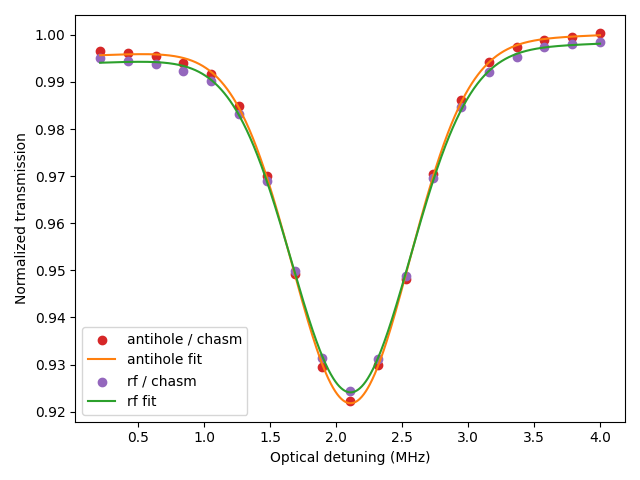

f_0 = 2.112(3)
a = -0.0760(4)
sigma = -0.445(3)
b = 0.00112(12)
c = 0.9978(2)
Reduced chi-square is undefined.

f_0 = 2.112(3)
a = -0.0720(4)
sigma = -0.451(3)
b = 0.00107(12)
c = 0.9961(2)
Reduced chi-square is undefined.


In [615]:
plt_monitor = False
use_positive = True

# antihole_normalized = antihole_avg/chasm_avg
antihole_normalized = antihole_avg/monitor_antihole_avg
# rf_normalized = rf_avg/chasm_avg
rf_normalized = rf_avg/monitor_rf_avg


if use_positive == True:
    mask = detunings_MHz > 0
elif use_positive == False:
    mask = detunings_MHz < 0
else:
    mask = detunings_MHz < 1e13

fig, ax = plt.subplots()
#ax.scatter(detunings_MHz, chasm_avg, label="chasm", color="C0")
#ax.scatter(detunings_MHz, antihole_avg, label="antihole", color="C1")
#ax.scatter(detunings_MHz, monitor_antihole_avg, label="antihole monitor", color="C2")
#ax.scatter(detunings_MHz, rf_avg, label="rf", color="C2")

#ax.scatter(detunings_MHz, antihole_normalized / 5.7, label="antihole / monitor", color="C1")
ax.scatter(detunings_MHz[mask], antihole_avg[mask]/chasm_avg[mask], label="antihole / chasm", color="C3")
antihole_fit = get_gaussian_fit(detunings_MHz[mask], antihole_avg[mask]/chasm_avg[mask], p0={"f_0": np.average(detunings_MHz[mask])})
xaxis = np.linspace(min(detunings_MHz[mask]), max(detunings_MHz[mask]), 1000)
ax.plot(xaxis, antihole_fit.fitted_value(xaxis), label = "antihole fit", color="C1")

if "rf_repeats" in headers["params"]["detect"]:
    #ax.scatter(detunings_MHz, rf_normalized / 5.7, label="rf / monitor", color="C2")
    ax.scatter(detunings_MHz[mask], rf_avg[mask]/chasm_avg[mask], label="rf / chasm", color="C4")
    #ax.scatter(detunings_MHz, monitor_rf_avg, label="rf monitor", color="C3")
    #ax.scatter(detunings_MHz, rf_avg, label="rf avg", color="C4")
    rf_fit = get_gaussian_fit(detunings_MHz[mask], rf_avg[mask]/chasm_avg[mask], p0={"f_0": np.average(detunings_MHz[mask])})
    ax.plot(xaxis, rf_fit.fitted_value(xaxis), label = 'rf fit', color="C2")
    pass
            
ax.set_xlabel("Optical detuning (MHz)")
ax.set_ylabel("Normalized transmission")
plt.legend()
plt.tight_layout()
plt.show()

print(antihole_fit.all_results_str())
print()
print(rf_fit.all_results_str())

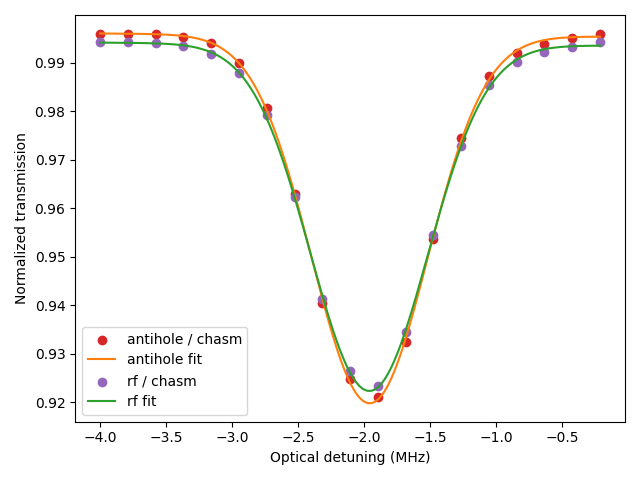

f_0 = -1.957(3)
a = -0.0760(4)
sigma = -0.439(3)
b = -0.00017(12)
c = 0.9957(2)
Reduced chi-square is undefined.

f_0 = -1.960(2)
a = -0.0715(3)
sigma = -0.444(3)
b = -0.00016(10)
c = 0.99385(17)
Reduced chi-square is undefined.


In [616]:
plt_monitor = False
use_positive = False

# antihole_normalized = antihole_avg/chasm_avg
antihole_normalized = antihole_avg/monitor_antihole_avg
# rf_normalized = rf_avg/chasm_avg
rf_normalized = rf_avg/monitor_rf_avg


if use_positive == True:
    mask = detunings_MHz > 0
elif use_positive == False:
    mask = detunings_MHz < 0
else:
    mask = detunings_MHz < 1e13

fig, ax = plt.subplots()
#ax.scatter(detunings_MHz, chasm_avg, label="chasm", color="C0")
#ax.scatter(detunings_MHz, antihole_avg, label="antihole", color="C1")
#ax.scatter(detunings_MHz, monitor_antihole_avg, label="antihole monitor", color="C2")
#ax.scatter(detunings_MHz, rf_avg, label="rf", color="C2")

#ax.scatter(detunings_MHz, antihole_normalized / 5.7, label="antihole / monitor", color="C1")
ax.scatter(detunings_MHz[mask], antihole_avg[mask]/chasm_avg[mask], label="antihole / chasm", color="C3")
antihole_fit = get_gaussian_fit(detunings_MHz[mask], antihole_avg[mask]/chasm_avg[mask], p0={"f_0": np.average(detunings_MHz[mask])})
xaxis = np.linspace(min(detunings_MHz[mask]), max(detunings_MHz[mask]), 1000)
ax.plot(xaxis, antihole_fit.fitted_value(xaxis), label = "antihole fit", color="C1")

if "rf_repeats" in headers["params"]["detect"]:
    #ax.scatter(detunings_MHz, rf_normalized / 5.7, label="rf / monitor", color="C2")
    ax.scatter(detunings_MHz[mask], rf_avg[mask]/chasm_avg[mask], label="rf / chasm", color="C4")
    #ax.scatter(detunings_MHz, monitor_rf_avg, label="rf monitor", color="C3")
    #ax.scatter(detunings_MHz, rf_avg, label="rf avg", color="C4")
    rf_fit = get_gaussian_fit(detunings_MHz[mask], rf_avg[mask]/chasm_avg[mask], p0={"f_0": np.average(detunings_MHz[mask])})
    ax.plot(xaxis, rf_fit.fitted_value(xaxis), label = 'rf fit', color="C2")
    pass
            
ax.set_xlabel("Optical detuning (MHz)")
ax.set_ylabel("Normalized transmission")
plt.legend()
plt.tight_layout()
plt.show()

print(antihole_fit.all_results_str())
print()
print(rf_fit.all_results_str())

In [596]:
def temporal_drift(data_list, use_monitor=True, use_positive=None):
    chasm_voltages = []
    antihole_offsets = []
    antihole_amplitudes = []
    antihole_f0s = []
    antihole_slopes = []
    antihole_gammas = []
    rf_offsets = []
    rf_amplitudes = []
    rf_f0s = []
    rf_slopes = []
    rf_gammas = []
    
    for kk in data_list:
        data, headers = get_experiment_data(kk)
        detunings = headers["detunings"].to("MHz").magnitude
        (chasm_avg, antihole_avg, rf_avg), (monitor_chasm_avg, monitor_antihole_avg, monitor_rf_avg) = data_groups(data, headers)

        if use_positive == True:
            mask = detunings > 0
        elif use_positive == False:
            mask = detunings < 0
        else:
            mask = detunings < 1e13
        chasm_voltages.append(np.average(chasm_avg))
        if use_monitor:
            antihole_fit = get_gaussian_fit(detunings[mask], antihole_avg[mask]/monitor_antihole_avg[mask], p0={"f_0": np.average(detunings[mask])})
        else:
            antihole_fit = get_gaussian_fit(detunings[mask], antihole_avg[mask]/chasm_avg[mask], p0={"f_0": np.average(detunings[mask])})
        antihole_amplitudes.append(antihole_fit.results["a"])
        #antihole_slopes.append(antihole_fit.results["b"])
        antihole_offsets.append(antihole_fit.results["c"])
        antihole_gammas.append(antihole_fit.results["sigma"])
        antihole_f0s.append(antihole_fit.results["f_0"])
        
        if use_monitor:
            rf_fit = get_gaussian_fit(detunings[mask], rf_avg[mask]/monitor_rf_avg[mask], p0={"f_0": np.average(detunings[mask])})
        else:
            rf_fit = get_gaussian_fit(detunings[mask], rf_avg[mask]/chasm_avg[mask], p0={"f_0": np.average(detunings[mask])})
        rf_amplitudes.append(rf_fit.results["a"])
        #rf_slopes.append(rf_fit.results["b"])
        rf_offsets.append(rf_fit.results["c"])
        rf_gammas.append(rf_fit.results["sigma"])
        rf_f0s.append(rf_fit.results["f_0"])

    return (
        np.array(chasm_voltages),
        np.array(antihole_offsets),
        np.array(antihole_amplitudes),
        np.array(antihole_f0s),
        np.array(antihole_slopes),
        np.array(antihole_gammas),
        np.array(rf_offsets),
        np.array(rf_amplitudes),
        np.array(rf_f0s),
        np.array(rf_slopes),
        np.array(rf_gammas),
    )

In [644]:
data_numbers = np.array(list(range(25136, 26222)))  # no field plate
data_numbers = np.array(list(range(26265, 27203)))  # field plate
data_numbers = np.array(list(range(27204, 27446)))  # field plate reversed Stark shift

a = -0.000005(3)
b = 0.9891(5)
Reduced chi-square is undefined.
f0 = 0.9885(2)
a = 30.4(1.7)
sigma = 0.0036(2)
Reduced chi-square is undefined.
a = -0.000006(4)
b = 0.9893(5)
Reduced chi-square is undefined.
f0 = 0.98883(19)
a = 27.7(1.2)
sigma = -0.00382(19)
Reduced chi-square is undefined.


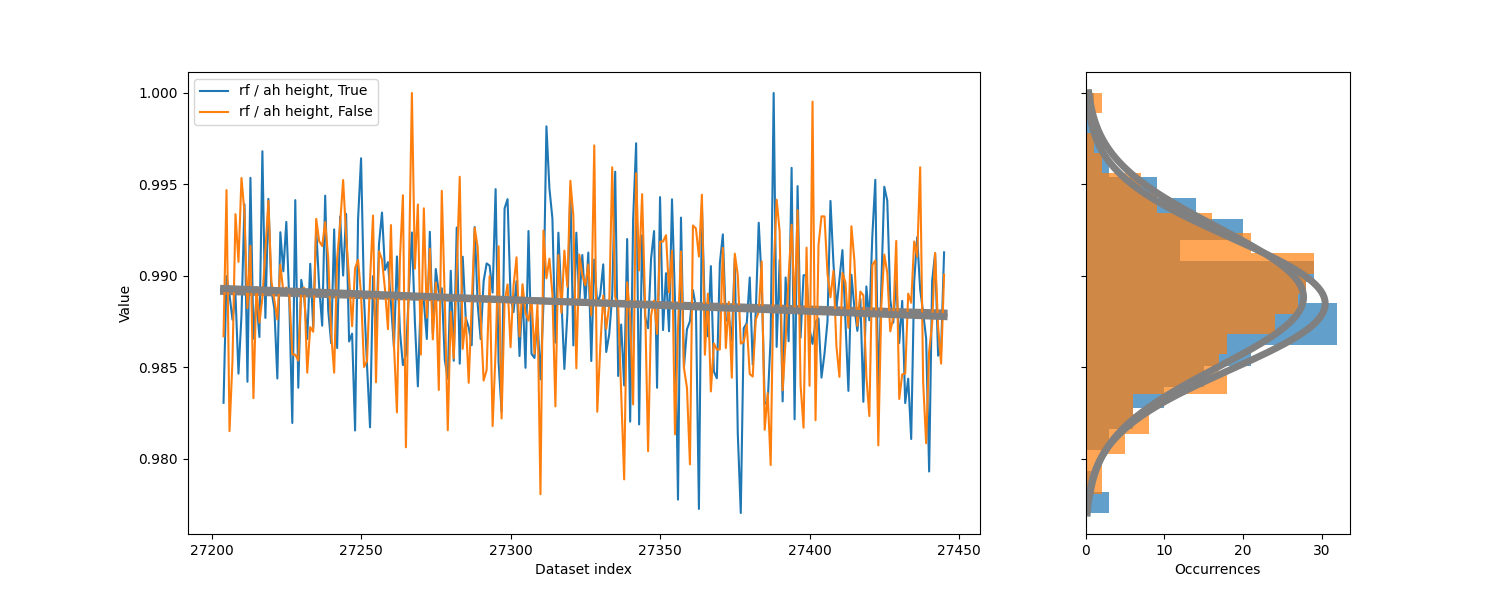

In [645]:
fig, axs = plt.subplots(1, 2, width_ratios=[3, 1], figsize=(15, 6), sharey=True)

ys = {}
xs = {}
for polarity in [True, False]:

    chasm_voltages, antihole_offsets, antihole_amplitudes, antihole_f0s, antihole_slopes, antihole_gammas, rf_offsets, rf_amplitudes, rf_f0s, rf_slopes, rf_gammas = temporal_drift(
        data_numbers, use_monitor=False, use_positive=polarity
    )
    rf_ah_height_ratio = rf_amplitudes / antihole_amplitudes / max(rf_amplitudes / antihole_amplitudes)
    axs[0].plot(data_numbers, rf_ah_height_ratio, label=f"rf / ah height, {polarity}")
    axs[0].set_xlabel("Dataset index")
    axs[0].set_ylabel("Value")
    axs[0].grid()
    axs[0].legend()
    
    fitter_linear = Fitter(linear)
    fitter_linear.set_absolute_sigma(False)
    fitter_linear.set_data(data_numbers - data_numbers[0], rf_ah_height_ratio)
    fitter_linear.fit()
    print(fitter_linear.all_results_str())
    axs[0].plot(data_numbers, fitter_linear.fitted_value(data_numbers - data_numbers[0]), color="gray", linewidth=5)
    
    
    hist, bin_edges = np.histogram(rf_ah_height_ratio, bins=20)
    bin_size = bin_edges[1] - bin_edges[0]
    bin_centers = bin_edges[1:] - bin_size / 2
    axs[1].barh(bin_centers, hist, height=bin_size, alpha=0.7)
    ys[polarity] = hist
    xs[polarity] = bin_centers
    
    plt_values = np.linspace(min(rf_ah_height_ratio), max(rf_ah_height_ratio), 200)
    fitter = Fitter(gaussian0)
    fitter.set_absolute_sigma(False)
    fitter.set_data(bin_centers, hist)
    fitter.set_p0({"f0": 0.99, "a": 1, "sigma": 1e-2})
    fitter.fit()
    axs[1].plot(fitter.fitted_value(plt_values), plt_values, color="gray", linewidth=5)
    axs[1].set_xlabel("Occurrences")
    print(fitter.all_results_str())
plt.show()

In [ ]:
# overnight: 29593 - 32592